In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.metrics import confusion_matrix
from IPython.display import display


In [28]:
raw = pd.DataFrame.from_csv('mean-stdev-raw-2.csv')
raw = raw.multiply(1e14)
norm = pd.DataFrame.from_csv('mean-stdev-norm-2.csv')
intra = pd.DataFrame.from_csv('mean-stdev-intra-2.csv')
inter = pd.DataFrame.from_csv('mean-stdev-inter-2.csv')

tags = np.array(['P'] * 10 + ['S'] * 10)
dfs = [raw, norm, intra, inter]

features = pd.concat(dfs, axis = 1)

numberOfShuffles = 500

sssCrossValTest = StratifiedShuffleSplit(n_splits = 1, test_size = 4)
sssTrainVal = StratifiedShuffleSplit(n_splits = numberOfShuffles, test_size = 4)
positiveLabel = 'S'

columnNames = ['Accuracy', 'F1', 'Precision', 'Recall', 'ROC AUC']


In [30]:
def calcAndPlotROCCurve(data, tags, ax = None, title = ''):
    fpr, tpr, thresholds = metrics.roc_curve(tags, data, pos_label = positiveLabel)
    roc_auc = metrics.auc(fpr, tpr)
    if not(ax is None):
        ax.plot(fpr, tpr, lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
        ax.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--', label = 'Random Guess')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC curve ' + title + ', Positive label = ' + positiveLabel)
        ax.legend(loc='lower right')
    return roc_auc

def highlight_3_yellow_3_normal(s):
#     return ['' for i, _ in enumerate(s)]
    return ['background-color: yellow' if 3 <= i % 6 <= 5 else '' for i, _ in enumerate(s)]

def getTruePositive(matrix):
    return matrix[1][1]

def getTrueNegative(matrix):
    return matrix[0][0]

def getFalsePositive(matrix):
    return matrix[0][1]

def getFalseNegative(matrix):
    return matrix[1][0]

def f1_precision_recall(y_val, predictions):
    conf_mat = confusion_matrix(y_val, predictions)
    truePositive = getTruePositive(conf_mat)
    falsePositive = getFalsePositive(conf_mat)
    falseNegative = getFalseNegative(conf_mat)
    
    f1 = None
    precision = None
    recall = None

    if truePositive == 0 or truePositive + falsePositive == 0 or truePositive + falseNegative == 0:
        f1 = float('nan')
    else:
        f1 = f1_score(y_val, predictions, pos_label = positiveLabel)

    if truePositive + falsePositive == 0:
        precision = float('nan')
    else:
        precision = precision_score(y_val, predictions, pos_label = positiveLabel)

    if truePositive + falseNegative == 0:
        recall = float('nan')
    else:
        recall = recall_score(y_val, predictions, pos_label = positiveLabel)
    return f1, precision, recall


## Para cada feature, computar la curva ROC y graficarla

In [31]:
def univariate1a(df):
    numberOfColumns = len(df.columns)
    halfNumberOfColumns = numberOfColumns / 2
    _, axs = plt.subplots(halfNumberOfColumns, 2, figsize = (20, 5 * halfNumberOfColumns))
    for i, colName in enumerate(df.columns):
        try:
            calcAndPlotROCCurve(df[colName], tags, axs[i % halfNumberOfColumns][0 if i < halfNumberOfColumns else 1], colName)
        except Exception:
            calcAndPlotROCCurve(df[colName], tags, axs[i], colName)
    try:
        plt.tight_layout()
    except Exception:
        pass
    plt.show()


### Features: Mean and StDev para cada Banda de frecuencias para los datos desnormalizados

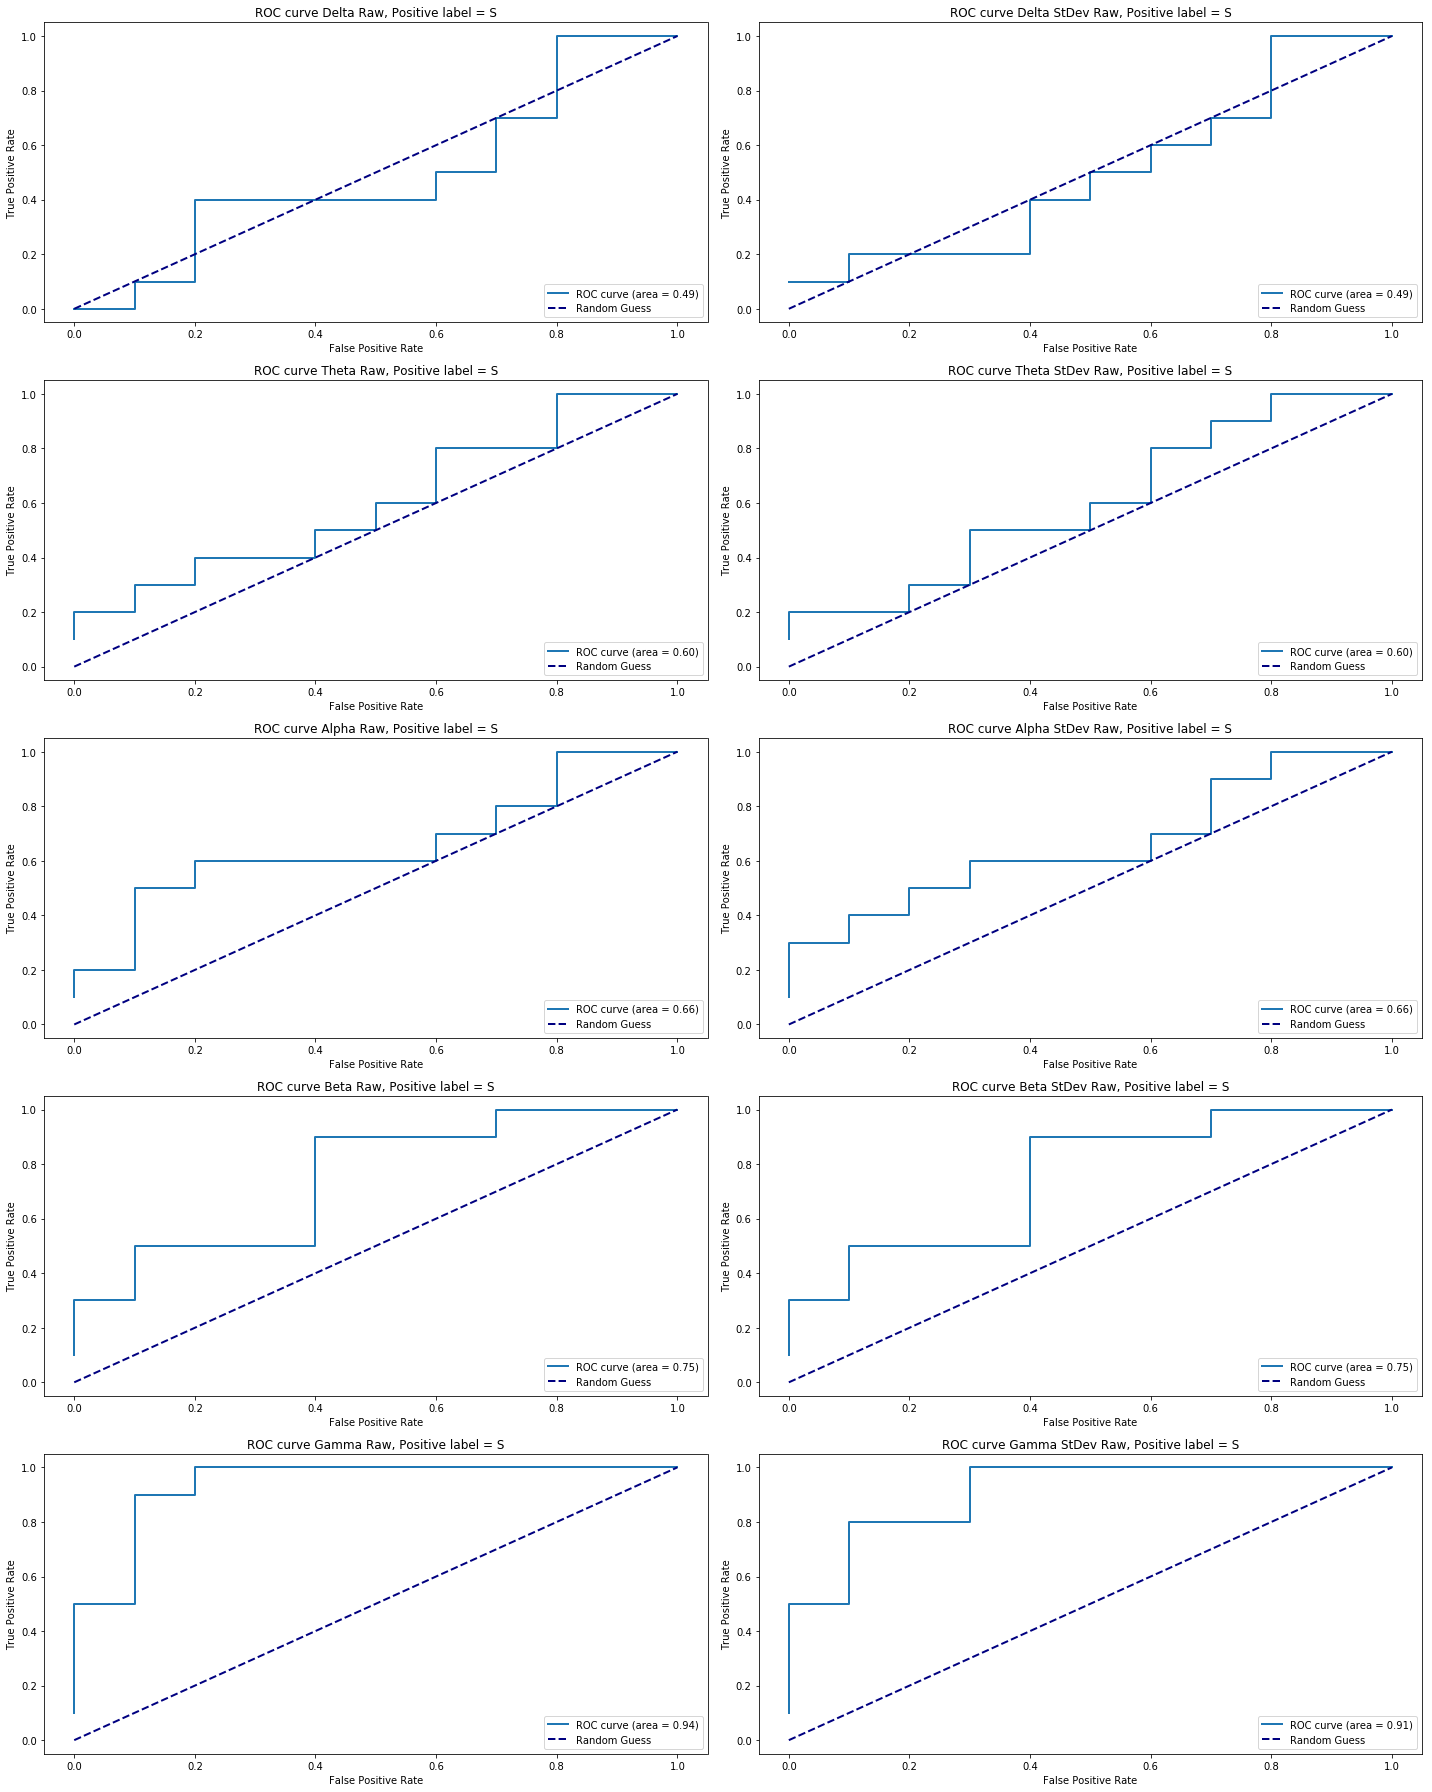

In [32]:
univariate1a(raw)


### Features: Mean and StDev para cada Banda de frecuencias para los datos normalizados

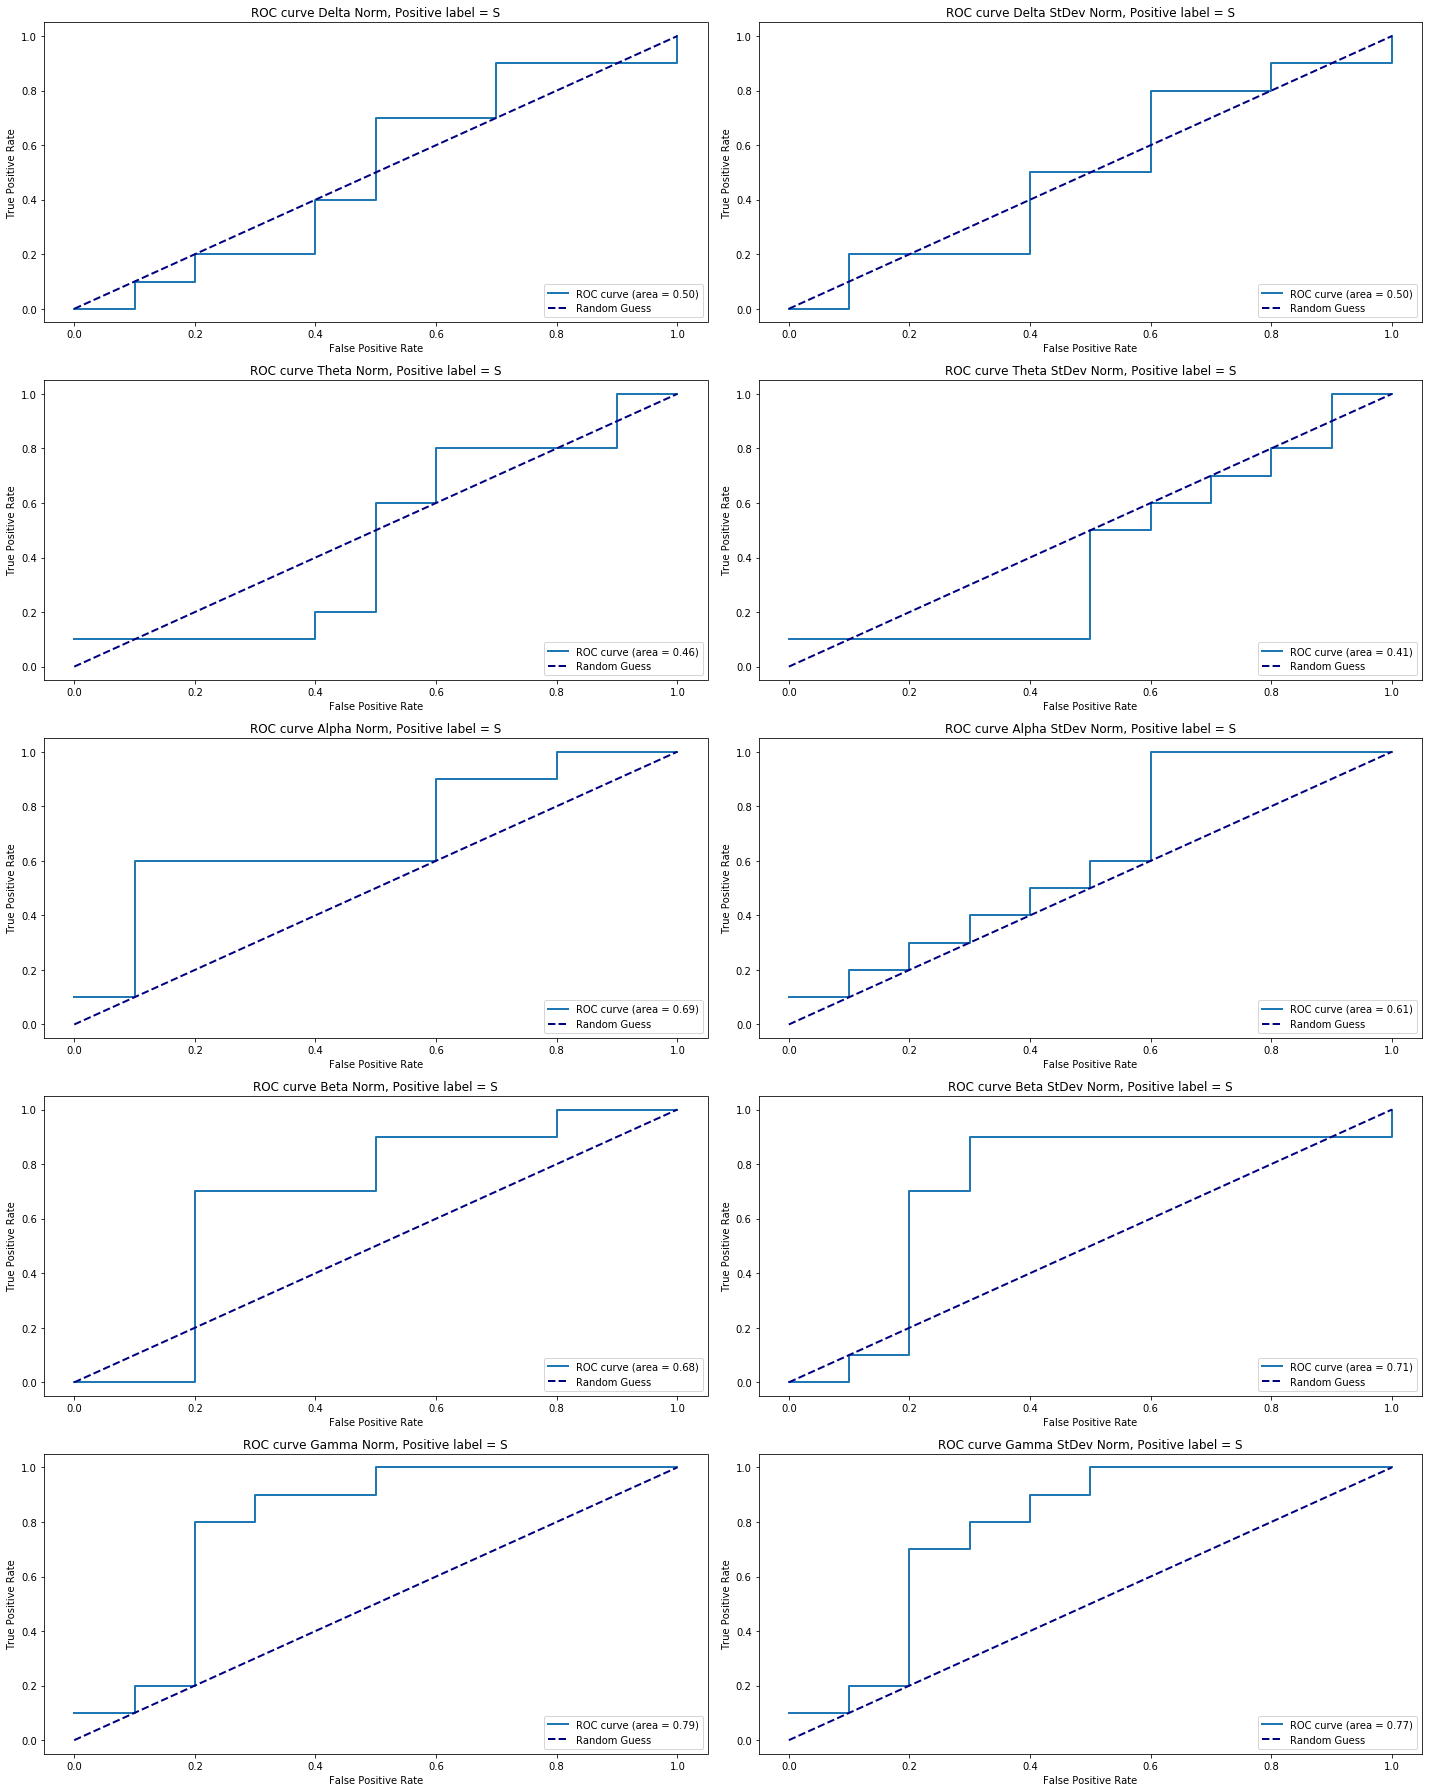

In [33]:
univariate1a(norm)


### Features: Mean and StDev para la medida intra-electrodo (entropía)

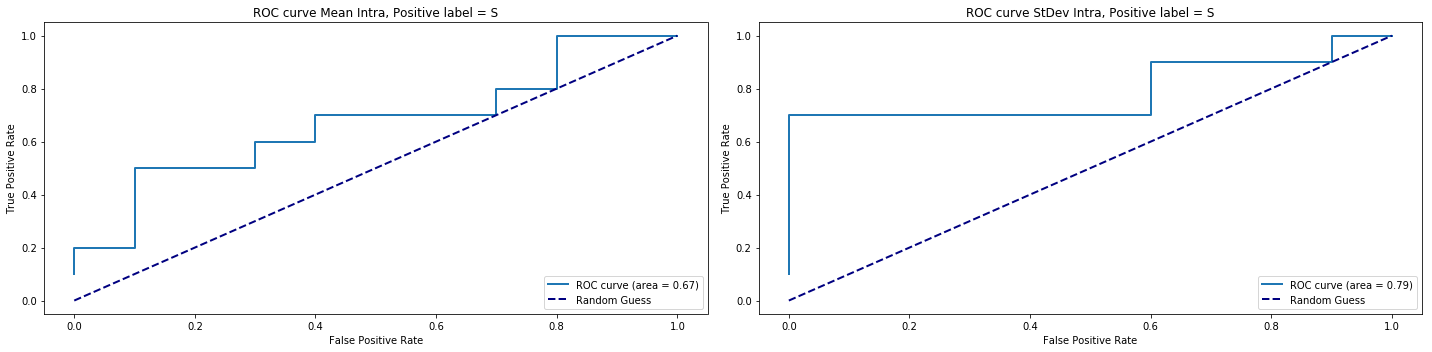

In [34]:
univariate1a(intra)


### Features: Mean and StDev para la medida inter-electrodo (entropía conjunta)

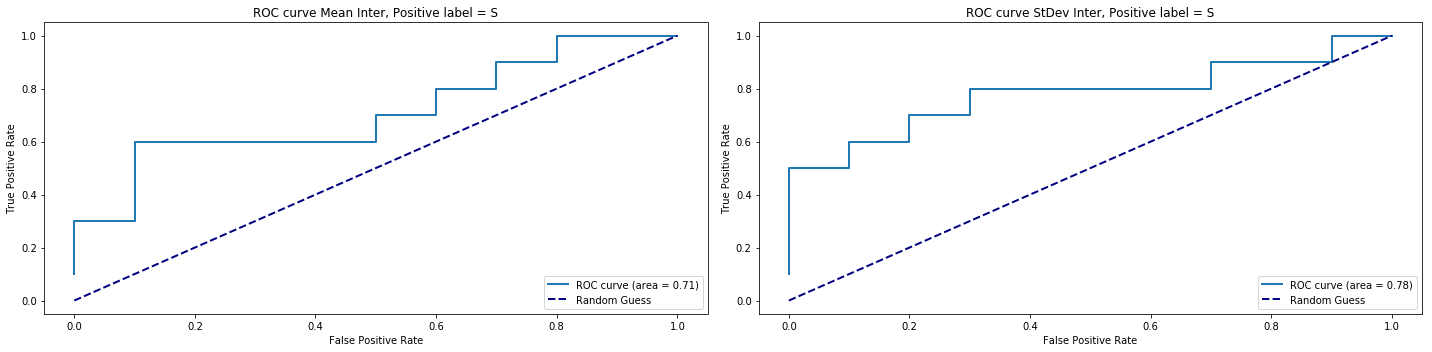

In [35]:
univariate1a(inter)


## Utilizando una técnica de cross validation, estimar la performance de un classificador Logistic Regression para cada feature y graficar la curva ROC correspondiente

In [36]:
def univariate1b(df):
    numberOfColumns = len(df.columns)
    halfNumberOfColumns = numberOfColumns / 2
    _, axs = plt.subplots(halfNumberOfColumns, 2, figsize = (20, 5 * halfNumberOfColumns))
    dataDF = pd.DataFrame(columns = columnNames)
    for i, colName in enumerate(df.columns):
        for cross_val_index, test_index in sssCrossValTest.split(df[colName], tags):
            X_cross_val, y_cross_val = df[colName].as_matrix()[cross_val_index], tags[cross_val_index]
            X_test, y_test = df[colName].as_matrix()[test_index], tags[test_index]

        accuracy, f1s, precisions, recalls, roc_aucs = [], [], [], [], []

        for train_index, val_index in sssTrainVal.split(X_cross_val, y_cross_val):
            X_train, y_train = X_cross_val[train_index], y_cross_val[train_index]
            X_val, y_val = X_cross_val[val_index], y_cross_val[val_index]

            clf = LogisticRegression()
            clf.fit(X_train.reshape(-1, 1), y_train)
            predictions = clf.predict(X_val.reshape(-1, 1))
            decision_function = clf.decision_function(X_val.reshape(-1, 1))

            accuracy.append(accuracy_score(y_val, predictions))

            f1, precision, recall = f1_precision_recall(y_val, predictions)
            if not math.isnan(f1):
                f1s.append(f1)
            if not math.isnan(precision):
                precisions.append(precision)
            if not math.isnan(recall):
                recalls.append(recall)

            roc_aucs.append(calcAndPlotROCCurve(decision_function, y_val))

        clf = LogisticRegression()
        clf.fit(X_cross_val.reshape(-1, 1), y_cross_val)
        decision_function = clf.decision_function(X_test.reshape(-1, 1))
        predictions = clf.predict(X_test.reshape(-1, 1))

        f1, precision, recall = f1_precision_recall(y_test, predictions)

        try:
            roc_auc = calcAndPlotROCCurve(decision_function, y_test, axs[i % halfNumberOfColumns][0 if i < halfNumberOfColumns else 1], colName)
        except Exception:
            roc_auc = calcAndPlotROCCurve(decision_function, y_test, axs[i], colName)

        dataDF = dataDF.append(pd.Series( \
            { \
                columnNames[0]: np.mean(accuracy), \
                columnNames[1]: np.mean(f1s), \
                columnNames[2]: np.mean(precisions), \
                columnNames[3]: np.mean(recalls), \
                columnNames[4]: np.mean(roc_aucs) \
            }).rename(colName + ' Mean'))
        dataDF = dataDF.append(pd.Series( \
            { \
                columnNames[0]: np.std(accuracy), \
                columnNames[1]: np.std(f1s), \
                columnNames[2]: np.std(precisions), \
                columnNames[3]: np.std(recalls), \
                columnNames[4]: np.std(roc_aucs) \
            }).rename(colName + ' StDev'))
        dataDF = dataDF.append(pd.Series( \
            { \
                columnNames[0]: accuracy_score(y_test, predictions), \
                columnNames[1]: f1, \
                columnNames[2]: precision, \
                columnNames[3]: recall, \
                columnNames[4]: roc_auc \
            }).rename(colName + ' Test'))

    dataDF = dataDF.style.apply(highlight_3_yellow_3_normal)
    display(dataDF)
    try:
        plt.tight_layout()
    except Exception:
        pass
    plt.show()


### Features: Mean and StDev para cada Banda de frecuencias para los datos desnormalizados

,Accuracy,F1,Precision,Recall,ROC AUC
Delta Raw Mean,0.3865,0.541921,0.373278,0.471,0.3495
Delta Raw StDev,0.191684,0.111082,0.257821,0.351652,0.249449
Delta Raw Test,0.5,0.5,0.5,0.5,0.5
Theta Raw Mean,0.389,0.502907,0.36099,0.383,0.357
Theta Raw StDev,0.182151,0.104785,0.243472,0.289501,0.253576
Theta Raw Test,0.5,0.666667,0.5,1,1
Alpha Raw Mean,0.733,0.756388,0.77381,0.732,0.7155
Alpha Raw StDev,0.201149,0.18365,0.24245,0.308506,0.265866
Alpha Raw Test,0.5,nan,nan,0,0.5
Beta Raw Mean,0.6515,0.734159,0.784145,0.456,0.7405


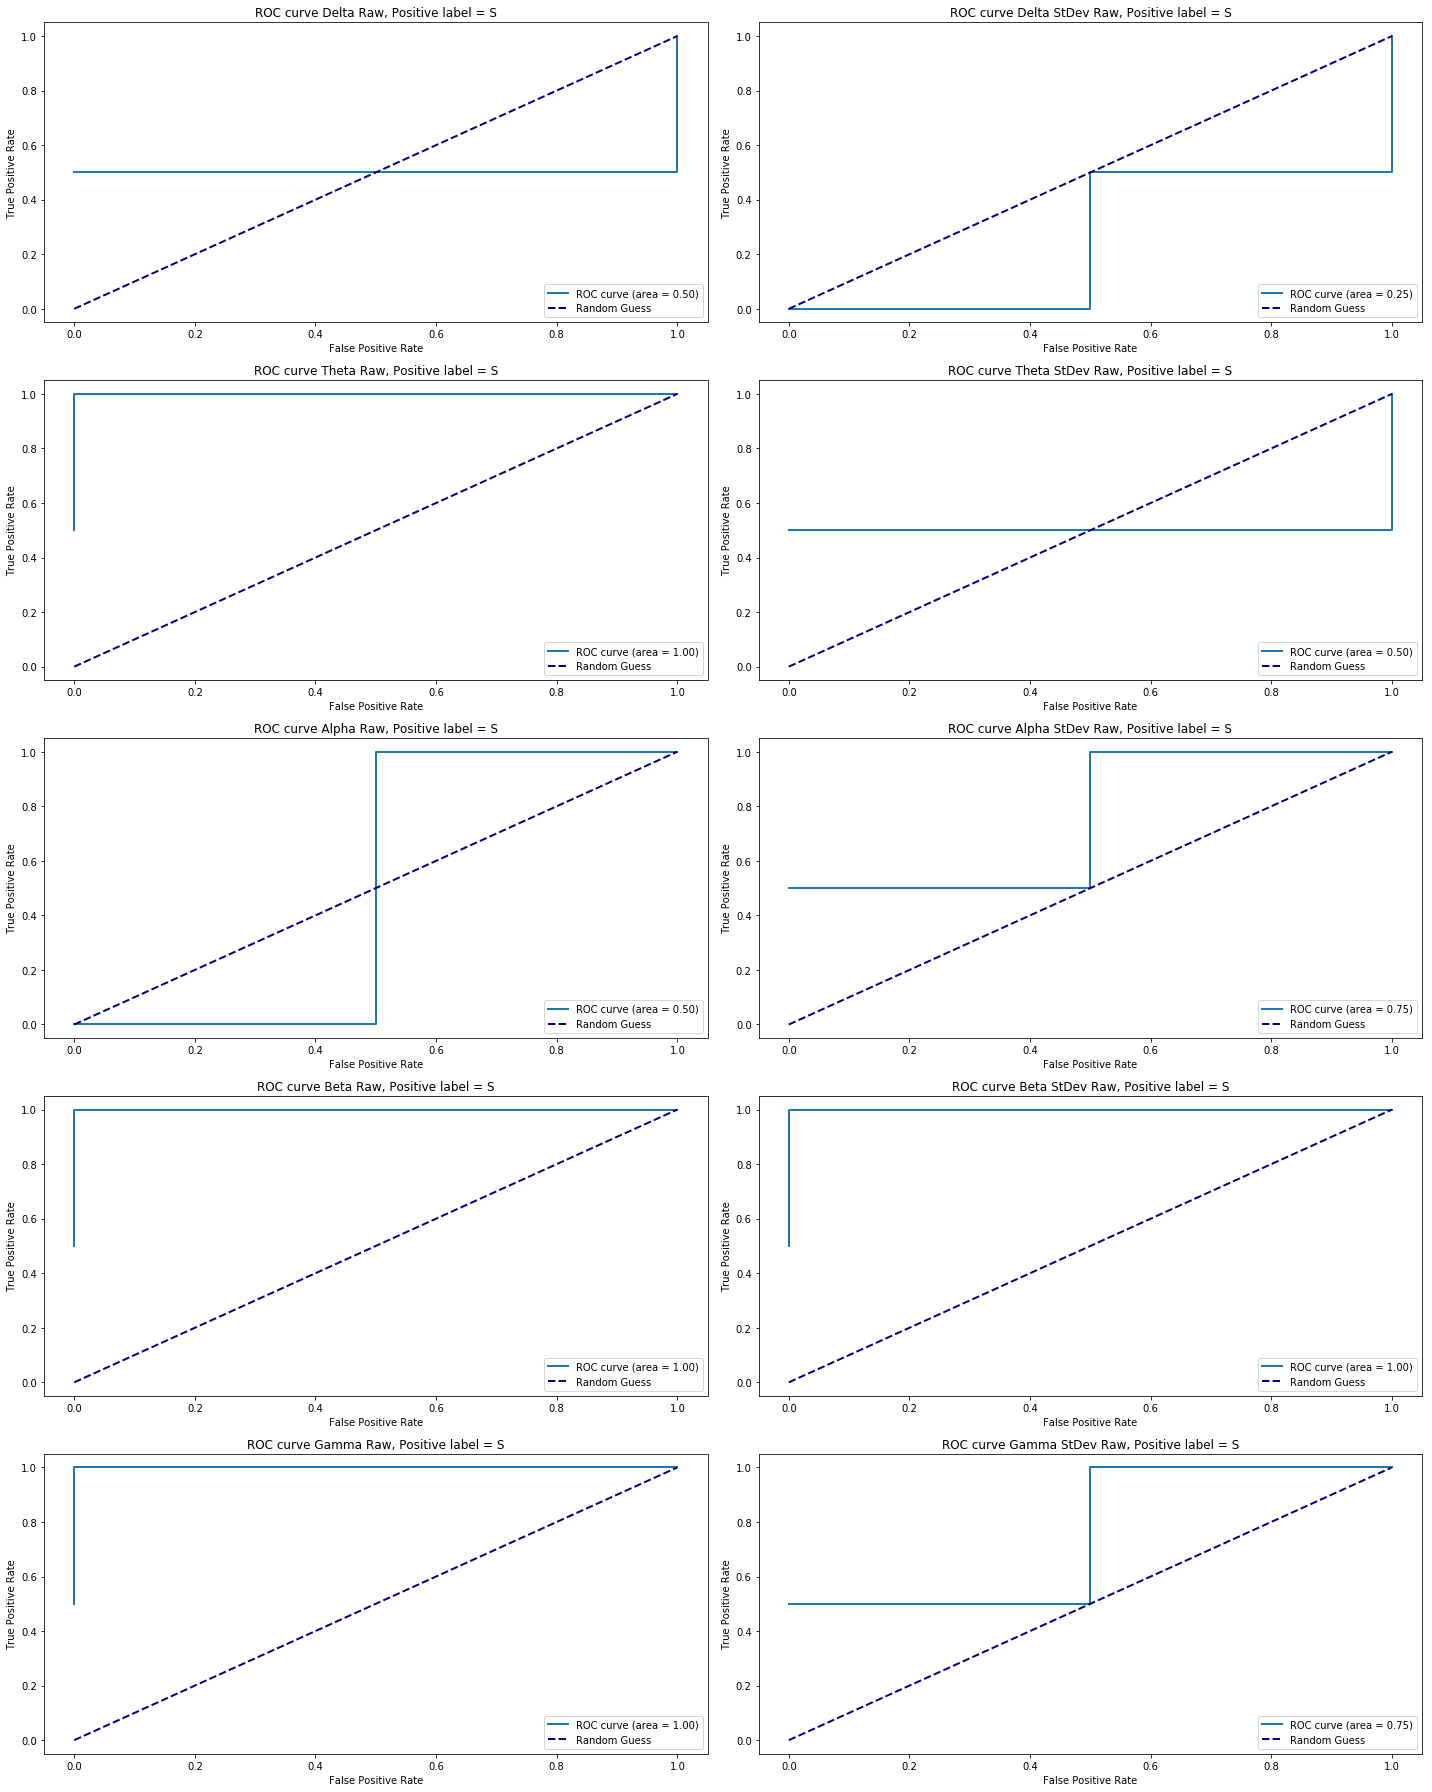

In [37]:
univariate1b(raw)


### Features: Mean and StDev para cada Banda de frecuencias para los datos normalizados

,Accuracy,F1,Precision,Recall,ROC AUC
Delta Norm Mean,0.3985,0.535307,0.363095,0.38,0.2865
Delta Norm StDev,0.193191,0.12153,0.265225,0.348712,0.206259
Delta Norm Test,0.5,0.666667,0.5,1,0.5
Theta Norm Mean,0.3905,0.558117,0.346365,0.481,0.303
Theta Norm StDev,0.19592,0.138078,0.242046,0.378337,0.231173
Theta Norm Test,0.25,nan,0,0,0.5
Alpha Norm Mean,0.5305,0.607549,0.552061,0.497,0.704
Alpha Norm StDev,0.216667,0.15563,0.319773,0.324794,0.260546
Alpha Norm Test,0.5,0.666667,0.5,1,0.5
Beta Norm Mean,0.3725,0.558177,0.354125,0.525,0.2695


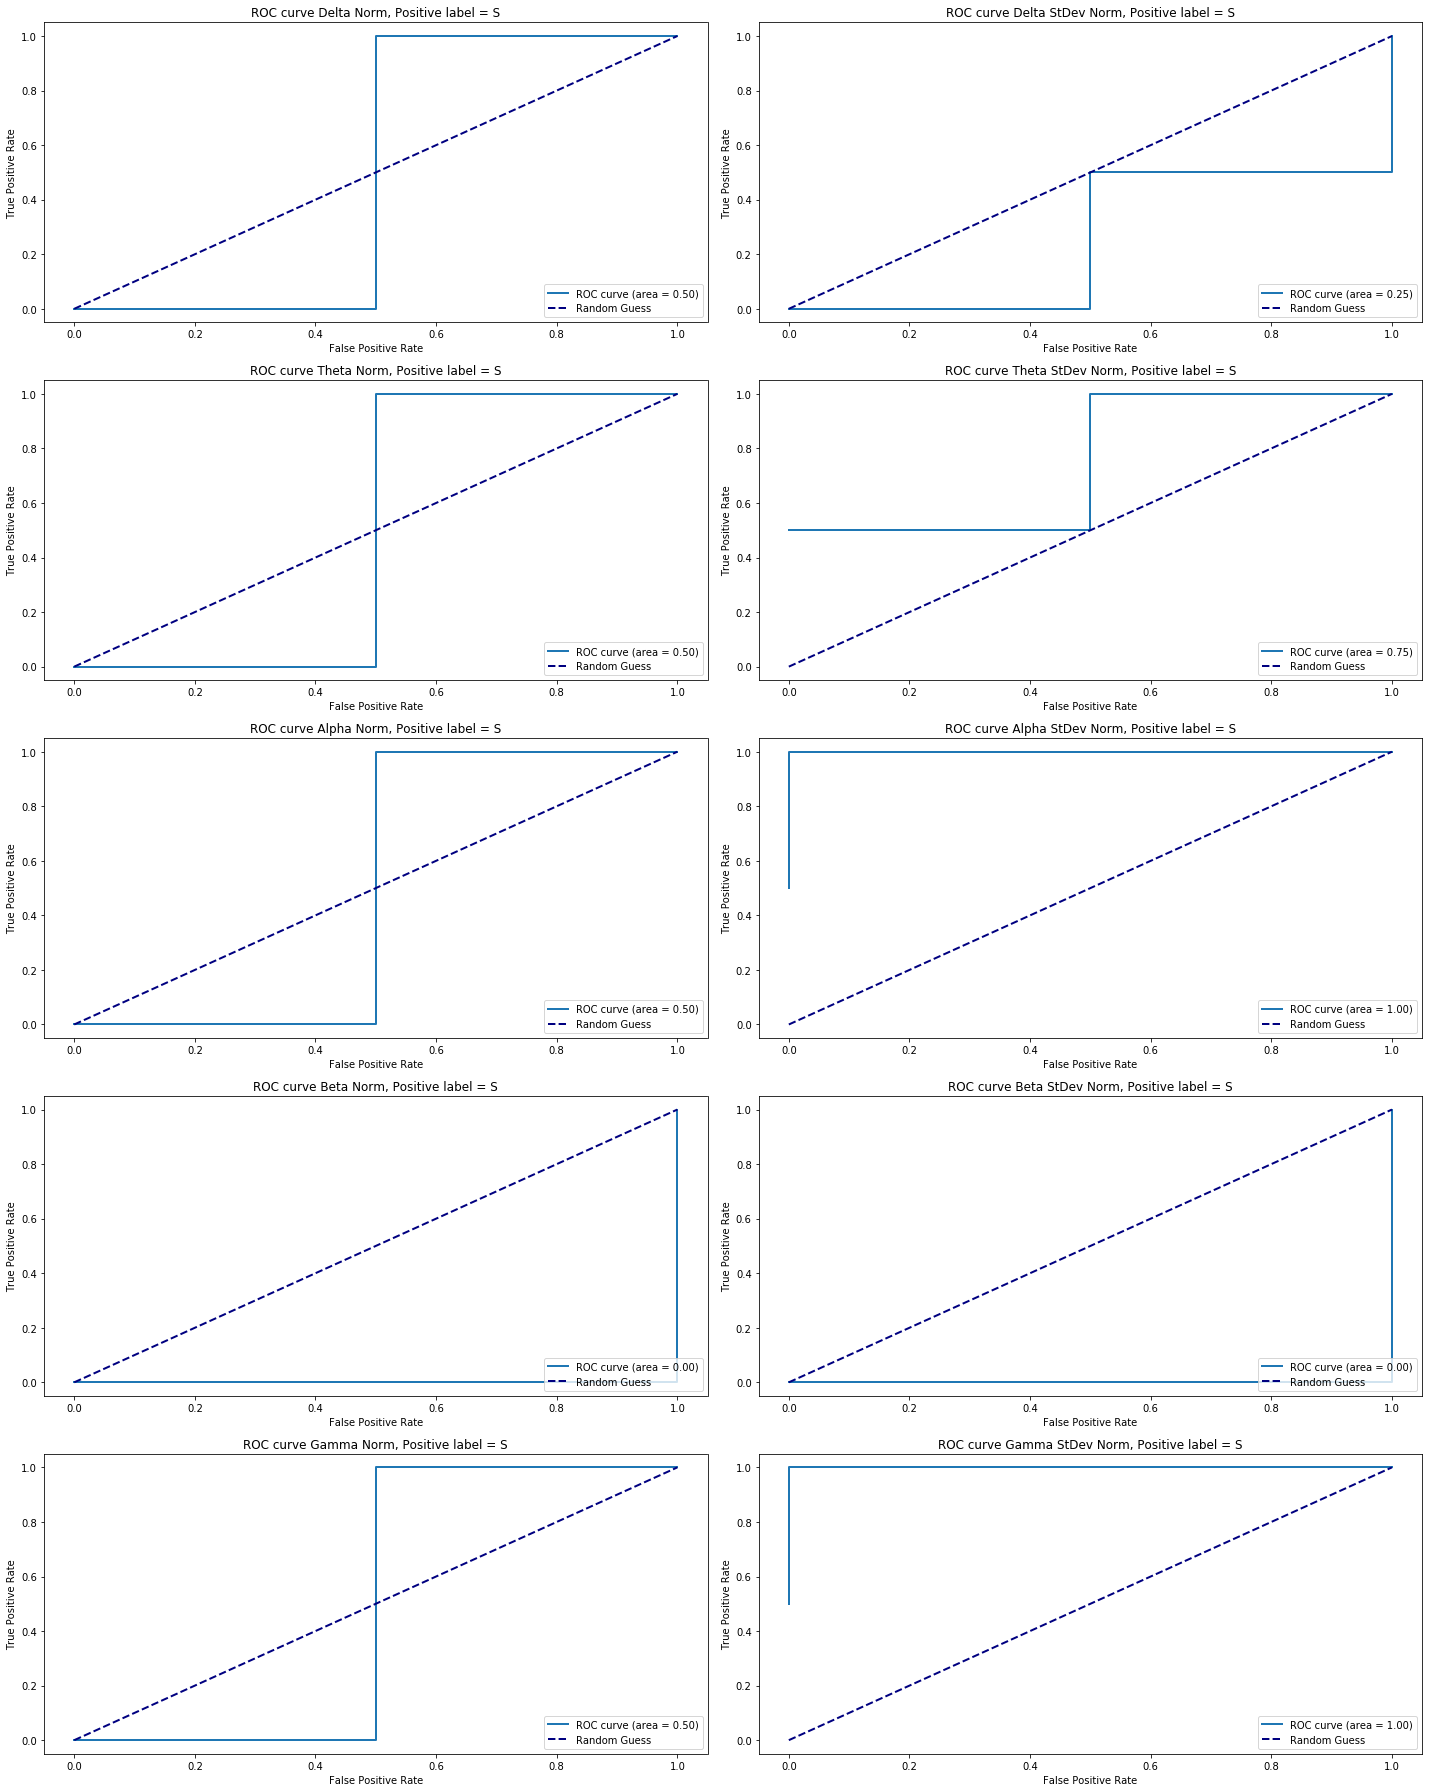

In [38]:
univariate1b(norm)


### Features: Mean and StDev para la medida intra-electrodo (entropía)

,Accuracy,F1,Precision,Recall,ROC AUC
Mean Intra Mean,0.578,0.661447,0.581818,0.77,0.727
Mean Intra StDev,0.201037,0.151198,0.211577,0.288271,0.264992
Mean Intra Test,0.25,0.4,0.333333,0.5,0.5
StDev Intra Mean,0.685,0.715469,0.702236,0.762,0.8325
StDev Intra StDev,0.201928,0.179239,0.229463,0.27451,0.227637
StDev Intra Test,0.25,0.4,0.333333,0.5,0.5


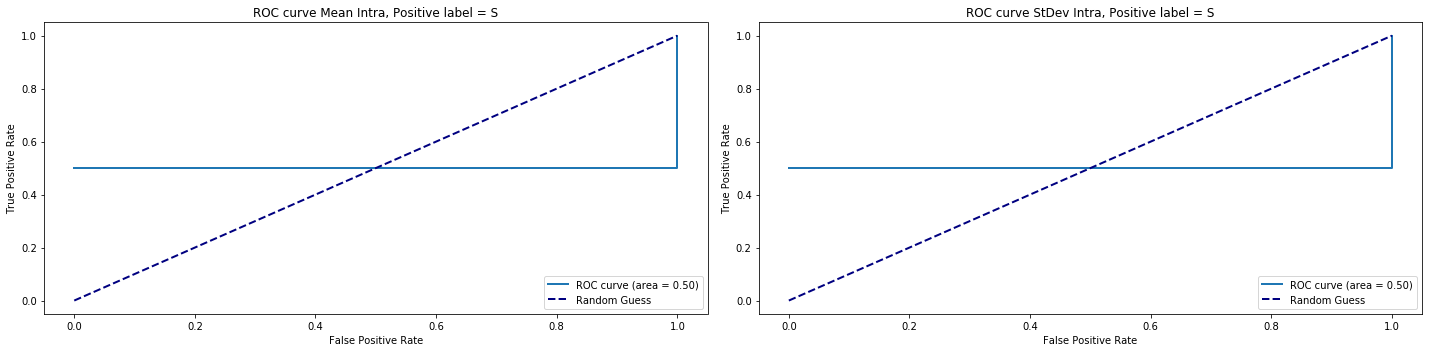

In [39]:
univariate1b(intra)


### Features: Mean and StDev para la medida inter-electrodo (entropía conjunta)

,Accuracy,F1,Precision,Recall,ROC AUC
Mean Inter Mean,0.393,0.533247,0.382022,0.549,0.418
Mean Inter StDev,0.153463,0.136107,0.177023,0.366195,0.286838
Mean Inter Test,0.75,0.666667,1,0.5,1
StDev Inter Mean,0.7955,0.814335,0.839876,0.812,0.944
StDev Inter StDev,0.179735,0.160328,0.211885,0.282234,0.125952
StDev Inter Test,0.5,0.5,0.5,0.5,0.5


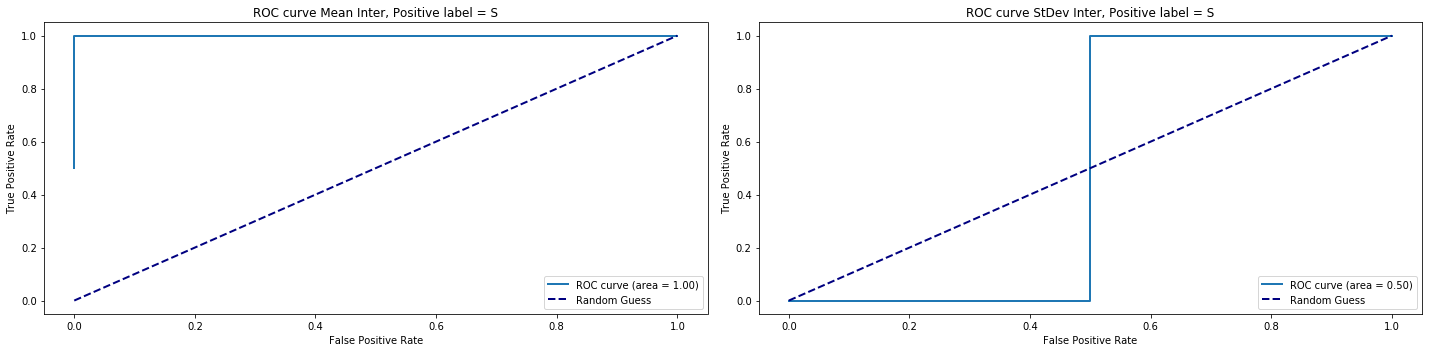

In [13]:
univariate1b(inter)


### Observaciones

Como el subconjunto de test es tan pequeño (4 sujetos), realmente no creemos que los resultados sean muy representativos: creemos que puede ser mejor comparar features mirando las medias y desvíos estandar de los promedios de los resultados obtenidos en CV, aunque somos conscientes de que pueden estar sesgados por haber overfitting en los mismos - por esta razón decidimos de todas formas dejar los resultados sobre la partición de test.

En las filas de las tablas donde se presentan los resultados en las cuales se ve "nan", es porque esos scores no están definidos para ese caso en particular, porque los denominadores de los cálculos que los computan dan cero (por ejemplo, F1 cuando precision + recall = 0).

### ¿Cuál es su conclusión respecto a los resultados obtenidos en el punto anterior?

Respecto a los resultados de las curvas ROC para los datos desnormalizados, podemos observar que la potencia en la banda gamma parecería ser un sorprendentemente buen clasificador para los tipos de sujetos: su AUC es de 0.94. Para las otras bandas de frecuencia, los resultados no son tan prometedores: beta tiene un AUC de 0.74, y las otras bandas aún menores.

Respecto a los datos normalizados, los valores de AUC son mucho peores, aunque igual la potencia de gamma sigue siendo la feature que mejor parece clasificar a los sujetos. Creemos que la diferencia entre los datos normalizados y desnormalizados se debe básicamente a errores numéricos, dado que los valores son muy pequeños.

Respecto a las medidas intra e inter electrodo, ninguna presenta grandes resultados (AUC alrededor del 0.67 y 0.71), pero la entropía conjunta es relativamente mejor. Esto puede tener sentido, ya que no observa localmente un electrodo, sino que tiene en cuenta más en general la actividad cerebral de los sujetos.

Para entrenar y analizar la performance del clasificador por regresión logística (y más adelante, SVM), primero dividimos el dataset aislando 4 sujetos para tener como set de test. Luego, entre los 16 restantes, aislamos otros 4 para validación, e hicimos 500 iteraciones de cross-validation (mutando las particiones). Los resultados presentados arriba muestran la media y el desvío estandar del promedio de los resultados obtenidos haciendo cross validation, y de los resultados obtenidos corriendo el clasificador sobre los sujetos de test.

Una observación: como el subconjunto de test es tan pequeño (4 sujetos), realmente no creemos que los resultados sean muy representativos: creemos que puede ser mejor comparar features mirando las medias y desvíos estandar de los promedios de los resultados obtenidos en CV, aunque somos conscientes de que pueden estar sesgados por haber overfitting en los mismos - por esta razón decidimos de todas formas dejar los resultados sobre la partición de test.

Entrenando al clasificados sobre las distintas bandas de frecuencias, encontramos nuevamente que la banda gamma es la que más información nos da: tenemos un F1 y Precision cercanos a 0.9, y un AUC de la curva ROC correspondiente, de 0.92. Sin embargo, sigue siendo más bajo que el valor obtenido simplemente clasificando a partir del valor, y dado que  es mucho más costoso entrenar un clasificador que simplemente comparar por el valor de una feature, no creemos que tenga sentido usar el clasificador cuando podemos obtener mejores resultados sólo mirando una feature.

Para los datos normalizados, los resultados son bastante peores utilizando el clasificador (las AUC de las curvas ROC correspondientes no superan 0.3 en general, cuando estaban entre 0.5 y 0.7 sólo mirando los valores), excepto nuevamente para gamma, donde los resultados fueron hasta mejores utilizando el clasificador que no usándolo: AUC de 0.85.

Respecto a las medidas inter- e intra-electrodo, el clasificador de regresión logística entrenado sobre las mismas parece dar, casi siempre, peores resultados que usar directamente las medidas como clasificadores. En el único caso donde los resultados fueron bastante mejores fue en el recall para el intra-electrodo (0.77) lo cual es relativamente bueno, pero tiene un precision cercano a 0.6, que no es tan bueno y puede significar que marcó a demasiados sujetos como S: por esta razón, el F1 score está cercano a 0.58, que no es bueno.

Finalmente entonces, como se dijo más arriba, la feature que mejor particiona a los sujetos parece ser la potencia en la banda gamma; y basado en este análisis, los dos mejores clasificadores son, ya sea simplemente el valor de gamma, o un clasificador por regresión lineal sobre esta feature. Sin embargo, como su performance es tan similar pero el clasificador tiene el overhead de ser entrenado, puede ser más sensato utilizar directamente el valor de la feature para decidir.

Otra observación (más implementativa): en las filas de las tablas donde se presentan los resultados en las cuales se ve "nan", es porque esos scores no están definidos para ese caso en particular, porque los denominadores de los cálculos que los computan dan cero (por ejemplo, F1 cuando precision + recall = 0).

### Utilizar todos los features y entrenar un clasificador basado en Support Vector Machine. Computar la curva roc y graficarla. No olvidar reportar el area bajo la curva.

In [14]:
def multivariate2a(kernel):
    _, axs = plt.subplots(1, 1)
    dataDF = pd.DataFrame(columns = columnNames)

    for cross_val_index, test_index in sssCrossValTest.split(features, tags):
        X_cross_val, y_cross_val = features.as_matrix()[cross_val_index], tags[cross_val_index]
        X_test, y_test = features.as_matrix()[test_index], tags[test_index]

    accuracy, f1s, precisions, recalls, roc_aucs = [], [], [], [], []

    for train_index, val_index in sssTrainVal.split(X_cross_val, y_cross_val):
        X_train, y_train = X_cross_val[train_index], y_cross_val[train_index]
        X_val, y_val = X_cross_val[val_index], y_cross_val[val_index]

        clf = SVC(kernel = kernel)
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_val)
        decision_function = clf.decision_function(X_val)

        accuracy.append(accuracy_score(y_val, predictions))

        f1, precision, recall = f1_precision_recall(y_val, predictions)
        if not math.isnan(f1):
            f1s.append(f1)
        if not math.isnan(precision):
            precisions.append(precision)
        if not math.isnan(recall):
            recalls.append(recall)

        try:
            roc_aucs.append(calcAndPlotROCCurve(decision_function, y_val))
        except Exception:
            roc_aucs.append(calcAndPlotROCCurve(decision_function, y_val))

    clf = SVC(kernel = kernel)
    clf.fit(X_cross_val, y_cross_val)
    decision_function = clf.decision_function(X_test)
    predictions = clf.predict(X_test)
    
    f1, precision, recall = f1_precision_recall(y_test, predictions)

    dataDF = dataDF.append(pd.Series( \
        { \
            columnNames[0]: np.mean(accuracy), \
            columnNames[1]: np.mean(f1s), \
            columnNames[2]: np.mean(precisions), \
            columnNames[3]: np.mean(recalls), \
            columnNames[4]: np.mean(roc_aucs) \
        }).rename('Mean'))
    dataDF = dataDF.append(pd.Series( \
        { \
            columnNames[0]: np.std(accuracy), \
            columnNames[1]: np.std(f1s), \
            columnNames[2]: np.std(precisions), \
            columnNames[3]: np.std(recalls), \
            columnNames[4]: np.std(roc_aucs) \
        }).rename('StDev'))
    dataDF = dataDF.append(pd.Series( \
        { \
            columnNames[0]: accuracy_score(y_test, predictions), \
            columnNames[1]: f1, \
            columnNames[2]: precision, \
            columnNames[3]: recall, \
            columnNames[4]: calcAndPlotROCCurve(decision_function, y_test, axs) \
        }).rename('Test'))

    dataDF = dataDF.style.apply(highlight_3_yellow_3_normal)
    display(dataDF)
    try:
        plt.tight_layout()
    except Exception:
        pass
    plt.show()


,Accuracy,F1,Precision,Recall,ROC AUC
Mean,0.5395,0.626104,0.557746,0.563,0.483
StDev,0.224866,0.160141,0.315675,0.335456,0.283656
Test,0.75,0.666667,1,0.5,1


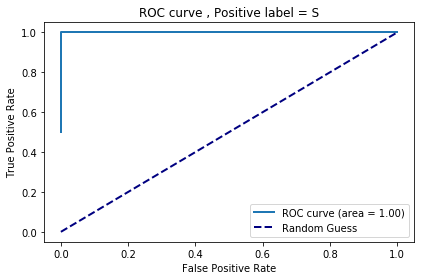

In [15]:
multivariate2a('linear')


### Repetir, pero utilizando un pipeline de Scikit-Learn con los siguientes 3 pasos:

1. Standard Scaler
2. Feature Selection utilizando solo el 10%.
3. SVC

In [16]:
def multivariate2b(percentile, kernel):
    _, axs = plt.subplots(1, 1)
    dataDF = pd.DataFrame(columns = columnNames)

    for cross_val_index, test_index in sssCrossValTest.split(features, tags):
        X_cross_val, y_cross_val = features.as_matrix()[cross_val_index], tags[cross_val_index]
        X_test, y_test = features.as_matrix()[test_index], tags[test_index]

    accuracy, f1s, precisions, recalls, roc_aucs = [], [], [], [], []

    for train_index, val_index in sssTrainVal.split(X_cross_val, y_cross_val):
        X_train, y_train = X_cross_val[train_index], y_cross_val[train_index]
        X_val, y_val = X_cross_val[val_index], y_cross_val[val_index]

        ss = StandardScaler()
        fs = SelectPercentile(percentile = percentile)
        clf = SVC(kernel = kernel)
        steps = [('Standard Scaler', ss), ('Feature Selection', fs), ('SVM', clf)]
        pipe = Pipeline(steps)
        pipe.fit(X_train, y_train)
        predictions = pipe.predict(X_val)

        transformed = fs.transform(X_val)
        decision_function = clf.decision_function(transformed)

        accuracy.append(accuracy_score(y_val, predictions))

        f1, precision, recall = f1_precision_recall(y_val, predictions)
        if not math.isnan(f1):
            f1s.append(f1)
        if not math.isnan(precision):
            precisions.append(precision)
        if not math.isnan(recall):
            recalls.append(recall)

        try:
            roc_aucs.append(calcAndPlotROCCurve(decision_function, y_val))
        except Exception:
            roc_aucs.append(calcAndPlotROCCurve(decision_function, y_val))

    ss = StandardScaler()
    fs = SelectPercentile(percentile = percentile)
    clf = SVC(kernel = kernel)
    steps = [('Standard Scaler', ss), ('Feature Selection', fs), ('SVM', clf)]
    pipe = Pipeline(steps)
    pipe.fit(X_cross_val, y_cross_val)

    predictions = pipe.predict(X_test)
    decision_function = pipe.decision_function(X_test)

    f1, precision, recall = f1_precision_recall(y_test, predictions)

    dataDF = dataDF.append(pd.Series( \
        { \
            columnNames[0]: np.mean(accuracy), \
            columnNames[1]: np.mean(f1s), \
            columnNames[2]: np.mean(precisions), \
            columnNames[3]: np.mean(recalls), \
            columnNames[4]: np.mean(roc_aucs) \
        }).rename('Mean'))
    dataDF = dataDF.append(pd.Series( \
        { \
            columnNames[0]: np.std(accuracy), \
            columnNames[1]: np.std(f1s), \
            columnNames[2]: np.std(precisions), \
            columnNames[3]: np.std(recalls), \
            columnNames[4]: np.std(roc_aucs) \
        }).rename('StDev'))
    dataDF = dataDF.append(pd.Series( \
        { \
            columnNames[0]: accuracy_score(y_test, predictions), \
            columnNames[1]: f1, \
            columnNames[2]: precision, \
            columnNames[3]: recall, \
            columnNames[4]: calcAndPlotROCCurve(decision_function, y_test, axs) \
        }).rename('Test'))

    dataDF = dataDF.style.apply(highlight_3_yellow_3_normal)
    display(dataDF)
    try:
        plt.tight_layout()
    except Exception:
        pass
    plt.show()


,Accuracy,F1,Precision,Recall,ROC AUC
Mean,0.5615,0.633242,0.614263,0.464,0.4805
StDev,0.217009,0.159719,0.339306,0.33868,0.312642
Test,1,1,1,1,1


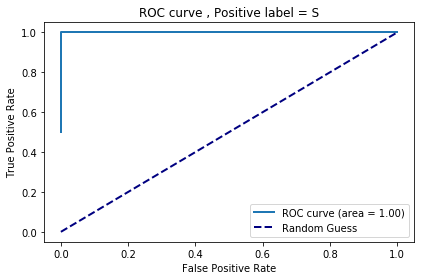

In [17]:
multivariate2b(10, 'linear')


### ¿Qué diferencia encuentra?

Comenzando por el análisis del clasificador SVM versus el pipeline con el 10% de los features, podemos observar que el área bajo la curva es muy similares en ambos casos (alrededor de 0.48), y representan un valor no deseado. Con esto podemos concluir que no hay diferencia entre tomar todos los features y tomar el 10%. Por otro lado, vemos diferencia al comparar recall y precision: al considerar el 10% de los features estamos perdiendo recall, pero generamos más precision (aunque en menor medida), por ende podemos pensar que tenemos más falsos negativos (marcamos varios sujetos como P cuando en realidad eran S) por parte del clasificador. Adicionalmente, F1 y accuracy tuvieron un leve incremento al entrenar SVM en un pipeline.

### ¿Y si utilizamos el 20% de los features?

Cuando seleccionamos el 20% de los features, notamos una mejora notable en relación a las dos pruebas anteriores: todas las medidas superaron un 0.7. Obtuvimos un AUC medio de 0.77, cuando antes teníamos un valor que no llegaba al 0.5; y precision y recall de 0.85 y 0.70, respectivamente. Creemos que la diferencia contra un feature selection del 10% se da porque con el 20% se consideran los suficientes features significativos que mejoran la calidad del clasificador (como mencionamos anteriormente, la potencia gamma es la que mejor clasifica a los sujetos S y P). Sin embargo, este resultado no basta para considerarlo como mejor clasificador que el indicado en el ejercicio anterior. 

,Accuracy,F1,Precision,Recall,ROC AUC
Mean,0.7685,0.795495,0.847072,0.695,0.765
StDev,0.196933,0.170657,0.246556,0.339816,0.309071
Test,0.5,nan,nan,0,0.5


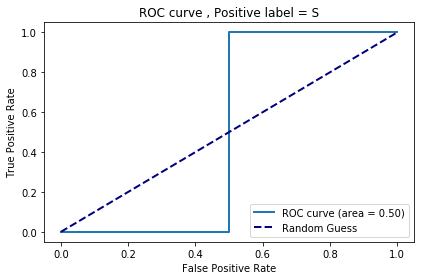

In [18]:
multivariate2b(20, 'linear')


### ¿Qué pasa si probamos y encontramos que utilizando el 35% de los features obtenemos la mejor AUC?

Respecto a la experimentación del pipeline tomando el 35% de los features, la calidad de todos los resultados bajaron notablemente respecto al percentil 20: una curva ROC con AUC de 0.4, cuando antes teníamos casi el doble. En este caso, creemos que integramos features que no permiten generar un buen clasificador: por ejemplo, vimos que un clasificador sobre beta generaba curvas ROC con AUC menor a 0.5. Si comparamos con la primera ejecución de SVM, los valores de accuracy, F1, recall y precision tuvieron una leve mejora, siendo este último el más considerado (un aumento de aproximadamente 0.14).  

A medida que vamos entrenando con más features, observamos que los resultados no mejoran y se mantienen muy similares, por lo que refuerza la idea de que estamos integrando features que no aportan un buen score para nuestro clasificador SVM. Además, concluimos que con una combinación de features no superamos los valores ni la performance del mejor clasificador encontrado (pues SVM requiere ser entrenado, al igual que linear regression).

,Accuracy,F1,Precision,Recall,ROC AUC
Mean,0.6355,0.686888,0.686825,0.588,0.398
StDev,0.217405,0.16735,0.310332,0.338018,0.27358
Test,1,1,1,1,1


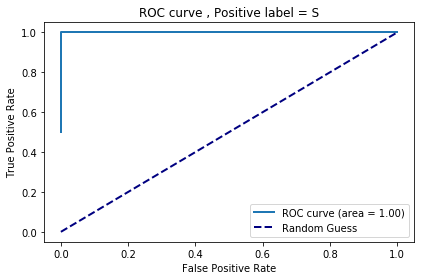

In [19]:
multivariate2b(35, 'linear')


,Accuracy,F1,Precision,Recall,ROC AUC
Mean,0.5965,0.671697,0.646789,0.538,0.496
StDev,0.244055,0.191746,0.327335,0.355747,0.307789
Test,0.75,0.666667,1,0.5,1


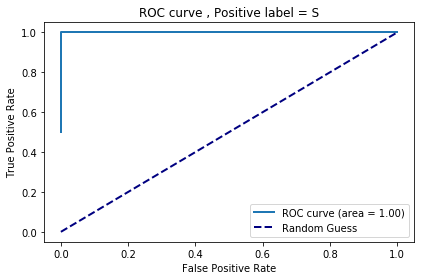

In [20]:
multivariate2b(50, 'linear')


,Accuracy,F1,Precision,Recall,ROC AUC
Mean,0.6095,0.658799,0.678241,0.51,0.476
StDev,0.210083,0.166828,0.31467,0.333017,0.297782
Test,0.75,0.666667,1,0.5,0.75


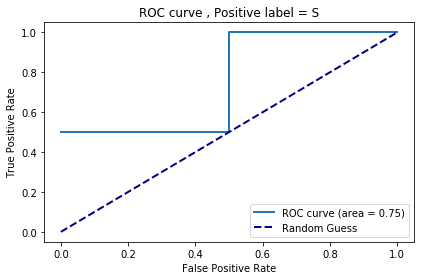

In [21]:
multivariate2b(70, 'linear')
